# Ch 7 - Ensemble Learning and Random Forests

This JN contains the code for Ch7. See the corresponding notes for more details.

## Hard Voting Classifier

Here, we will illustrate how to make a basic ensemble ML algorithm that implements the "hard voting" strategy (ie. majority vote).

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
log_classifier = LogisticRegression(random_state=42)
forest_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42)

In [4]:
voting_classifier = VotingClassifier(
    estimators = [("lr", log_classifier), ("rf", forest_classifier), ("svc", svm_classifier)],
    voting = "hard"
)

In [5]:
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

We can check the accuracy of each individual classifer, as well as the ensemble voting classifier:

In [6]:
from sklearn.metrics import accuracy_score

for classifier in [log_classifier, forest_classifier, svm_classifier, voting_classifier]:
    classifier.fit(X_train, y_train)
    y_predictions = classifier.predict(X_test)
    print(classifier.__class__.__name__ , accuracy_score(y_test, y_predictions))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


As expected, the ensemble voting classifier does indeed outperform each of the individual classifiers (although it is not really THAT much better than the SVM in this case).

**Soft Voting**

In an attempt to increase the ensemble accuracy even further, we can try an ensemble method called **soft voting**. Here, we proceed in a similar way - create various classifiers individually, and pass a new input instance to each to get their individual predictions.

NOW: Instead of doing a majority vote (hard voting), we would instead compute the class probabilities for each individual classifier, take the average of the probability for each class over the individual classifiers, and make the prediction for the class with the highest average.

In order to do this, each of the individual classifiers need to be equipped with the 'predict_proba()' method. As we know, the SVC does not come with this method by default, so for that particular classifier, we must get it to implement cross-validation by setting the hyperparameter 'probability' to "True". Although this will slow down training, you will be able to then compute class probabilities.

Finally, to implement soft voting, we simply specify the hyperparameter 'voting' to "soft", in the VotingClassifier class instantiation.

In [7]:
log_classifier = LogisticRegression(random_state=42)
forest_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42, probability=True)

In [8]:
voting_classifier = VotingClassifier(
    estimators = [("lr", log_classifier), ("rf", forest_classifier), ("svc", svm_classifier)],
    voting = "soft" # !!!!!
)

In [9]:
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

The accuracy for soft voting is compute below:

In [10]:
from sklearn.metrics import accuracy_score

for classifier in [log_classifier, forest_classifier, svm_classifier, voting_classifier]:
    classifier.fit(X_train, y_train)
    y_predictions = classifier.predict(X_test)
    print(classifier.__class__.__name__ , accuracy_score(y_test, y_predictions))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


We see that we get a slightly better accuracy for our ensemble classifier when using soft voting instead of hard voting.

## Bagging and Pasting in SKL

To illustrate an implementation of bagging (exact same for pasting), we will use the same moons dataset above and train 500 decision tree classifiers, each of which will be trained on subsets of the training data of size 100.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
bag_classifier = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 500, # Specify the number of (above) decision trees we want
    max_samples = 100, # Specify the number of random training instances for each estimator
    bootstrap = True, # Specify whether you want bagging (True) or pasting (False)
    n_jobs = -1, # Specify the number of CPU cores to use (-1 means all)
    random_state=42
)

In [13]:
bag_classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

We can compare the accuracy of this bagging ensemble with just using a single decision tree. We first make a single decision tree classifier, then compare the accuracy.

In [14]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [15]:
tree_predictions = tree_classifier.predict(X_test)
bagging_predictions = bag_classifier.predict(X_test)

In [16]:
print("Decision tree accuracy: ", accuracy_score(tree_predictions, y_test))
print("Bagging accuracy: ", accuracy_score(bagging_predictions, y_test))

Decision tree accuracy:  0.856
Bagging accuracy:  0.904


As expected, the bagging ensemble performs better than just a single decision tree.

We can also visualize the decision boundaries of each and compare them:

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Text(0, 0.5, '')

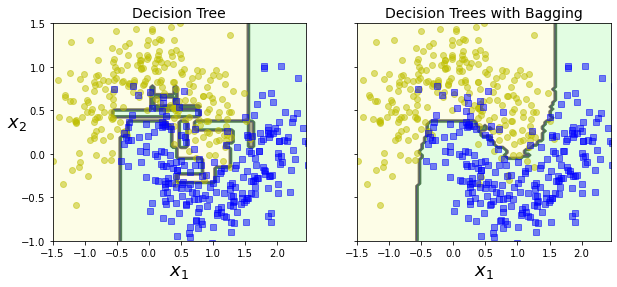

In [18]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_classifier, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_classifier, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

### Out-of-Bag Evaluation

We can easily specify SKL to use and compute oob evaluations for each predictor by simply specifying the 'oob_score' hyperparameter to "True" (in the 'BaggingClassifier' instantiation).

The evaluation scores can then be extracted from the 'oob_score_' variable.

In [19]:
bag_classifier_oob = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 500, # Specify the number of (above) decision trees we want
    max_samples = 100, # Specify the number of random training instances for each estimator
    bootstrap = True, # Specify whether you want bagging (True) or pasting (False)
    n_jobs = -1, # Specify the number of CPU cores to use (-1 means all)
    random_state=42,
    oob_score = True
)

In [20]:
bag_classifier_oob.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

In [21]:
bag_classifier_oob.oob_score_

0.9253333333333333

As we can see, using oob evaluation, we get that this bagging ensemble will have about 92.53% accuracy with new data! *Recall: This is called the generalization error we are trying to estimate.*

We can check this accuracy by using the test set:

In [22]:
bag_oob_predictions = bag_classifier_oob.predict(X_test)

In [23]:
accuracy_score(bag_oob_predictions, y_test)

0.904

We can also view the decision function generated through the training process using the 'oob_decision_function_' variable.

If the base estimator is capable of computing class probabilities, then the decision function will return them.

In [24]:
bag_classifier_oob.oob_decision_function_

array([[0.35579515, 0.64420485],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.01030928, 0.98969072],
       [0.03174603, 0.96825397],
       [0.07672634, 0.92327366],
       [0.39189189, 0.60810811],
       [0.06145251, 0.93854749],
       [0.92689295, 0.07310705],
       [0.88205128, 0.11794872],
       [0.59850374, 0.40149626],
       [0.04896907, 0.95103093],
       [0.7565445 , 0.2434555 ],
       [0.81377551, 0.18622449],
       [0.88528678, 0.11471322],
       [0.07407407, 0.92592593],
       [0.04738155, 0.95261845],
       [0.92051282, 0.07948718],
       [0.69974555, 0.30025445],
       [0.94358974, 0.05641026],
       [0.06100796, 0.93899204],
       [0.224     , 0.776     ],
       [0.9125964 , 0.0874036 ],
       [0.98746867, 0.01253133],
       [0.95967742, 0.04032258],
       [0.        , 1.        ],
       [0.94255875, 0.05744125],
       [1.        , 0.        ],
       [0.03466667, 0.96533333],
       [0.7020202 , 0.2979798 ],
       [0.

## Random Forests

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(n_estimators = 500,
                                            max_leaf_nodes = 16,
                                            n_jobs = -1)

forest_classifier.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [26]:
forest_predictions = forest_classifier.predict(X_test)

In [27]:
np.sum(bagging_predictions == forest_predictions) / len(bagging_predictions)

0.976

We see that using the 'RandomForestClassifier' yields approximately the exact same predictions as using the 'BaggingClassifier' with decision trees.

**Feature Importance**

In [28]:
from sklearn.datasets import load_iris

iris = load_iris()

forest_classifier_iris = RandomForestClassifier(n_estimators=500, n_jobs=-1)
forest_classifier_iris.fit(iris["data"], iris["target"])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [29]:
for name, score in zip(iris["feature_names"], forest_classifier_iris.feature_importances_):
    print(name, score)

sepal length (cm) 0.08458799382372739
sepal width (cm) 0.02127915401052426
petal length (cm) 0.44989546991137824
petal width (cm) 0.44423738225437015


## Boosting

**AdaBoost**

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_classifier = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=1),
                                         n_estimators=200,
                                         algorithm="SAMME.R",
                                         learning_rate=0.5)

#### NOTE: A decision tree with a height of one is called a "decision stump"!

In [31]:
ada_boost_classifier.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [32]:
ada_boost_predictions = ada_boost_classifier.predict(X_test)

In [33]:
print(accuracy_score(ada_boost_predictions, y_test))

0.896


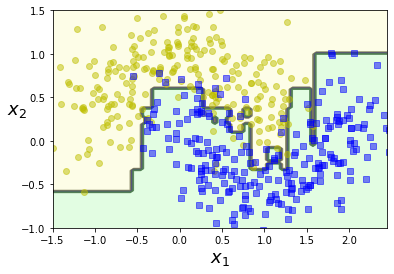

In [34]:
plot_decision_boundary(ada_boost_classifier, X, y)

**Gradient Boosting**

In [41]:
np.random.seed(42)

X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [42]:
from sklearn.tree import DecisionTreeRegressor

In [43]:
tree_regressor_1 = DecisionTreeRegressor(max_depth=2)
tree_regressor_1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [44]:
y2 = y - tree_regressor_1.predict(X) # These are the *residual errors* of the FIRST tree!

tree_regressor_2 = DecisionTreeRegressor(max_depth=2)
tree_regressor_2.fit(X, y2) # Fitting to the residual errors y2

DecisionTreeRegressor(max_depth=2)

In [45]:
y3 = y2 - tree_regressor_2.predict(X) # These are the *residual errors* of the SECOND tree!

tree_regressor_3 = DecisionTreeRegressor(max_depth=2)
tree_regressor_3.fit(X, y3) # Fitting to the residual errors y3

DecisionTreeRegressor(max_depth=2)

We now have our ensemble consisting of three decision tree regressors. To make predictions, we simply sum the predictions of each individual predictor:

In [48]:
X_new = np.array([[0.8]])

grad_boost_predictions = sum(tree.predict(X_new) for tree in [tree_regressor_1, tree_regressor_2, tree_regressor_3])
grad_boost_predictions

array([0.75026781])

We implemented gradient boosting from scratch, but we could have also used SKL's 'GradientBoostingRegressor' class as well:

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [50]:
gbrt.predict(X_new)

array([0.75026781])

**Early Stopping Implementation**

In order to determine the appropriate number of trees we should use, we can implement early stopping in the GBRT code above. Then we can investigate what number of trees minimizes the validation error. We use the method 'staged_predict()', as shown below.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

In [64]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

In [65]:
# We now determine the minimum validation error and the associated number of trees

errors = [mean_squared_error(y_val, y_pred)
             for y_pred in gbrt.staged_predict(X_val)]

best_num_trees = np.argmin(errors)+1
min_error = errors[best_num_trees]

In [66]:
print("Minimum validation error: ", min_error)
print("Optimal number of trees: ", best_num_trees)

Minimum validation error:  0.002730216353395411
Optimal number of trees:  110


Now, we can train a new GBRT ensemble with this optimum number of trees:

In [67]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=best_num_trees, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=110, random_state=42)

In [70]:
gbrt.predict(X_new)

array([0.7389862])

In [71]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Text(0.5, 0, '$x_1$')

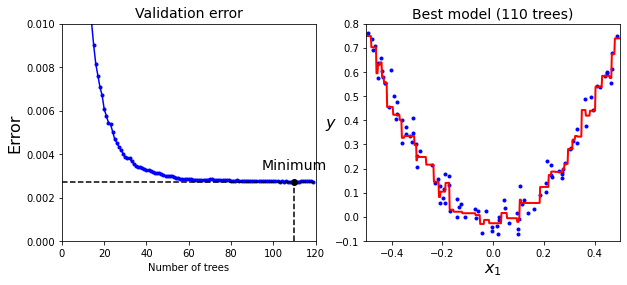

In [72]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_num_trees, best_num_trees], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_num_trees, min_error, "ko")
plt.text(best_num_trees, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_num_trees, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

In the above method, we had to train **TWO** different GBRT ensembles. This is because we needed the first one to finish in its entirety so that we could look into the validation errors.

It's also possible to **truly** implement early stopping, in the sense that we stop training once we reach a minimum validation error. This second technique is shown below. Notice we specify 'warm_start' to be "True":

In [61]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

In [73]:
min_val_error = float("inf")
error_going_up = 0

for num_predictors in range(1,120):
    gbrt.n_estimators = num_predictors
    gbrt.fit(X_train, y_train)
    
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:  #### When valiadation error does not improve for 5 consecutive iterations
            break                #### Breaking here for early stopping!
            

In [76]:
print("Minimum validation error: ", min_val_error)
print("Optimal number of trees: ", num_predictors)

Minimum validation error:  0.0028209980081892543
Optimal number of trees:  72


## XGBoost - A Quick Note

***I could not get XGBoost to install properly, try harder next time!***

In [77]:
import xgboost

ModuleNotFoundError: No module named 'xgboost'